# Plot how distance between song-driven MA trajectories changes over time conditioned on song mass

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal, stats
from sklearn import linear_model
import sys
import warnings; warnings.filterwarnings("ignore")

from aux import get_seg, rand_string
from disp import set_plot, plot_b, colors
from my_stats import nanpearsonr

cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

# Load natural song snippets

In [2]:
STRAINS = ['NM91', 'ZH23']
FSTRAIN = 'data/simple/strains.csv'

MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()

In [3]:
# load natural songs
df_song = pd.read_csv('data/simple/c_song_f_behav.csv')[['ID', 'T', 'Q', 'S', 'P' ,'F']]
sngs_full = []
for itr in ISTRAIN:
    df_tr = df_song[df_song['ID'] == itr]
    sng_full = np.zeros(len(df_tr), dtype=int)
    sng_full[df_tr['S'] == 1] = 1
    sng_full[(df_tr['P'] == 1) | (df_tr['F'] == 1)] = 2
    sngs_full.append(sng_full)

In [4]:
N = 20
tau_r = np.random.uniform(120, 120, N)
tau_a = np.random.uniform(.1, 2, N)
x_s = np.random.uniform(0, 1, N)
x_p = np.random.uniform(0, 1, N)
# minh = np.random.rand(N) < .5
# x_s[minh] *= -1
# x_p[minh] *= -1

In [5]:
def smlt_v(i_s, i_p, tau_r, tau_a, x_s, x_p, dt):
    t = np.arange(len(i_s))*dt
    n = len(tau_a)
    
    vs = np.nan*np.zeros((len(t), n))
    vs[0, :] = 0
    
    rs = np.nan*np.zeros((len(t), n))
    rs[0, :] = 0
    
    a_ss = np.zeros((len(t), n))
    a_ps = np.zeros((len(t), n))
    
    for ct in range(1, len(t)):
        
        # update adapted input
        vs[ct, :] = x_s*(1-a_ss[ct-1, :])*i_s[ct] + x_p*(1-a_ps[ct-1, :])*i_p[ct]
        
        # update integral
        rs[ct, :] = rs[ct-1, :] + (DT/tau_r)*(-rs[ct-1, :] + vs[ct, :])
        
        # update adaptation variables
        da_s = (dt/tau_a)*(-a_ss[ct-1, :] + i_s[ct])
        a_ss[ct, :] = a_ss[ct-1, :] + da_s
        
        da_p = (dt/tau_a)*(-a_ps[ct-1, :] + i_p[ct])
        a_ps[ct, :] = a_ps[ct-1, :] + da_p
        
    return rs, vs, a_ss, a_ps, t

T_SNP 1: T_SNP 5: T_SNP 9: T_SNP 13: T_SNP 17: T_SNP 21: T_SNP 25: T_SNP 29: T_SNP 33: T_SNP 37: T_SNP 41: T_SNP 45: T_SNP 49: T_SNP 53: T_SNP 57: T_SNP 61: T_SNP 65: T_SNP 69: T_SNP 73: T_SNP 77: T_SNP 81: T_SNP 85: T_SNP 89: T_SNP 93: T_SNP 97: T_SNP 101: T_SNP 105: T_SNP 109: T_SNP 113: T_SNP 117: T_SNP 121: T_SNP 125: T_SNP 129: T_SNP 133: T_SNP 137: T_SNP 141: T_SNP 145: T_SNP 149: T_SNP 153: T_SNP 157: T_SNP 161: T_SNP 165: T_SNP 169: T_SNP 173: T_SNP 177: T_SNP 181: T_SNP 185: T_SNP 189: T_SNP 193: T_SNP 197: 

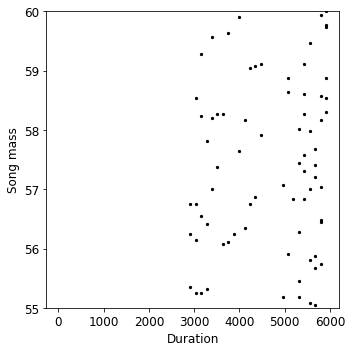

In [6]:
# get snippets
T_SNPS = range(1, 200, 4)

snps_all = []
durs = []
masses = []

# durs = []
# rs_final = []

for cT_SNP, T_SNP in enumerate(T_SNPS):
    sys.stdout.write(f'T_SNP {T_SNP}: ')
    
    NT_SNP = int(round(T_SNP*FPS))
    t_snp = np.arange(NT_SNP)*DT

    nsnp_max = np.inf #100

    min_gap = NT_SNP  #int(round(3*FPS))
    min_frac_sing = 0

    snps = []

    for csng, sng_full in enumerate(sngs_full):
        segs, bds = get_seg(sng_full > 0, min_gap=min_gap)
        segs = [sng_full[lb:ub] for lb, ub in bds]
        # keep fixed-length portions only of sufficiently long segments
        segs = [seg[:NT_SNP] for seg in segs if (len(seg) >= NT_SNP) and (np.mean(seg > 0) > min_frac_sing)]
        snps.extend(segs)

        if len(snps) > nsnp_max:
            break

    snps_all.extend(snps)
    masses.extend([np.sum(snp > 0)*DT for snp in snps])
    durs.extend([len(snp) for snp in snps])
    
masses = np.array(masses)
durs = np.array(durs)
    
fig, ax = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)
ax.scatter(durs, masses, c='k', s=5)
set_plot(ax, y_lim=(55, 60), x_label='Duration', y_label='Song mass')

In [12]:
WDW_MASS = 1
MASS_LBS = np.arange(0, 90, 5)
NTR = 30

ds = np.nan*np.zeros((len(MASS_LBS), NTR))

for cmass_lb, mass_lb in enumerate(MASS_LBS):
    print(f'Song mass = {mass_lb+WDW_MASS/2} s')
    mass_ub = mass_lb + WDW_MASS
    
    snp_mask = (mass_lb <= masses) & (masses < mass_ub)
    
    for ctr in range(NTR):
        sys.stdout.write('.')
        isnps = np.random.choice(snp_mask.nonzero()[0], 2, replace=False)
        basis = []

        # fig, axs = plt.subplots(1, 2, figsize=(6, 2.5), tight_layout=True)

        for isnp in isnps:
            snp = snps_all[isnp]
            i_s = (snp == 1).astype(float)
            i_p = (snp == 2).astype(float)

            t_snp = np.arange(len(snp))*DT

            rs_basis = smlt_v(i_s, i_p, tau_r, tau_a, x_s, x_p, DT)[0]

            basis.append(rs_basis[-1, :])
            
        basis = np.transpose(basis)
        d = np.linalg.norm(basis[:, 0] - basis[:, 1])
        
        ds[cmass_lb, ctr] = d
    print('')

Song mass = 0.5 s
..............................
Song mass = 5.5 s
..............................
Song mass = 10.5 s
..............................
Song mass = 15.5 s
..............................
Song mass = 20.5 s
..............................
Song mass = 25.5 s
..............................
Song mass = 30.5 s
..............................
Song mass = 35.5 s
..............................
Song mass = 40.5 s
..............................
Song mass = 45.5 s
..............................
Song mass = 50.5 s
..............................
Song mass = 55.5 s
..............................
Song mass = 60.5 s
..............................
Song mass = 65.5 s
..............................
Song mass = 70.5 s
..............................
Song mass = 75.5 s
..............................
Song mass = 80.5 s
..............................
Song mass = 85.5 s
..............................


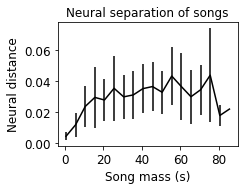

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.75), tight_layout=True)
ax.errorbar(MASS_LBS+WDW_MASS/2, ds.mean(1), yerr=ds.std(1), c='k')

set_plot(ax, x_label='Song mass (s)', y_label='Neural distance', title='Neural separation of songs')
# fig.savefig('ms/4_song_separation.svg')